# Common Spatial Pattern (CSP) on Close/Open Classification

In [4]:
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import signal 
from scipy.ndimage.filters import gaussian_filter
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from scipy.linalg import eigh
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

!python download_file_from_google_drive.py 1RA74erNCZzEeHU5rgpE8Enix8Orlty5X Close.mat
!python download_file_from_google_drive.py 1eOotaqZYvqaV5_bF60WPx8_3rNdT-jEW Open.mat

[LINE:43]# INFO     [2018-02-11 13:07:05,154]  Downloading google file id: 1RA74erNCZzEeHU5rgpE8Enix8Orlty5X
[LINE:44]# INFO     [2018-02-11 13:07:05,154]  Saving to: Close.mat
[LINE:10]# INFO     [2018-02-11 13:07:05,154]  Downloading 1RA74erNCZzEeHU5rgpE8Enix8Orlty5X to Close.mat
[LINE:11]# INFO     [2018-02-11 13:07:05,154]  Please be patient, it may take a while...
[LINE:824]# DEBUG    [2018-02-11 13:07:05,170]  Starting new HTTPS connection (1): docs.google.com
[LINE:396]# DEBUG    [2018-02-11 13:07:07,183]  https://docs.google.com:443 "GET /uc?export=download&id=1RA74erNCZzEeHU5rgpE8Enix8Orlty5X HTTP/1.1" 302 None
[LINE:824]# DEBUG    [2018-02-11 13:07:07,189]  Starting new HTTPS connection (1): doc-0o-b0-docs.googleusercontent.com
[LINE:396]# DEBUG    [2018-02-11 13:07:07,485]  https://doc-0o-b0-docs.googleusercontent.com:443 "GET /docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5t9bn8d89j0fj7d90mump74f9r0dn2uo/1518379200000/02109484880547918045/*/1RA74erNCZzEeHU5rgpE8Enix8Orlty5

In [234]:
close_mat = sio.loadmat('Close.mat')['Close']
open_mat = sio.loadmat('Open.mat')['Open']

close_segments = close_mat['data'][0, 0]
open_segments = open_mat['data'][0, 0]


print('Shape of Close trials: ',close_segments.shape)
print('Shape of Open trials: ',open_segments.shape)
fs = close_mat['fs'].item(0)[0,0].astype('int')
print('Sampling frequency: %d Hz'%fs)

ms_before = close_mat['ms_before'].item(0)[0,0].astype('float')
ms_after = close_mat['ms_after'].item(0)[0,0].astype('float')
freq_low = 60 # High Gamma Band 60-200 Hz
freq_high = 200 

baseline_time = np.array([0.6, 1.3]) # baseline segment
baseline_sample= np.arange((fs*baseline_time[0]).astype('int'), fs*baseline_time[1], dtype = 'int')

move_time = np.array([1.3, 2]) # movement segment
move_sample = np.arange((fs*move_time[0]).astype('int'), fs*move_time[1], dtype = 'int')

print('Sample number of each trial: %d'%close_segments.shape[0])
print('Total Channel number: %d'%close_segments.shape[1])
print('Trial number of Close: %d'%close_segments.shape[2])
print('Trial number of Open: %d'%open_segments.shape[2])

Shape of Close trials:  (1501, 114, 25)
Shape of Open trials:  (1501, 114, 22)
Sampling frequency: 500 Hz
Sample number of each trial: 1501
Total Channel number: 114
Trial number of Close: 25
Trial number of Open: 22


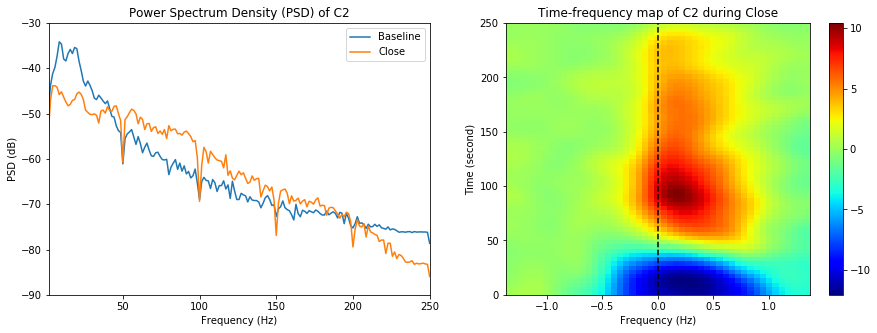

In [235]:
# Show the PSD of C2 averaged over trials
f_base, Pxx_base = signal.periodogram(close_segments[baseline_sample, 2, :], fs, axis = 0)
f_move, Pxx_move = signal.periodogram(close_segments[move_sample, 2, :], fs, axis = 0)

Pxx_base = np.mean(Pxx_base, 1)
Pxx_move = np.mean(Pxx_move, 1)

f, t, Sxx = signal.spectrogram(close_segments[:, 2, :], fs, nperseg=128, noverlap=100, axis = 0)
Sxx = np.mean(Sxx, axis = 1);

Sxx = Sxx/np.mean(Sxx[:, 1:12], axis = 1, keepdims = True)
plt.subplot(1, 2, 1)
plt.plot(f_base, 10*np.log10(Pxx_base))
plt.plot(f_move, 10*np.log10(Pxx_move))
plt.xlim([2, 250])
plt.ylim([-90, -30])
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (dB)')
plt.title('Power Spectrum Density (PSD) of C2')
plt.legend(('Baseline', 'Close'))

plt.subplot(1, 2, 2)
plt.pcolormesh(t-1.5, f, gaussian_filter(10*np.log10(Sxx), 2), cmap='jet', clim = [-6, 6])
plt.colorbar()
plt.plot([0, 0], [0, 250], 'k--')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Time (second)')
plt.title('Time-frequency map of C2 during Close')

plt.gcf().set_size_inches(15, 5)
plt.show()

Overlay plots of all channels for the first trial


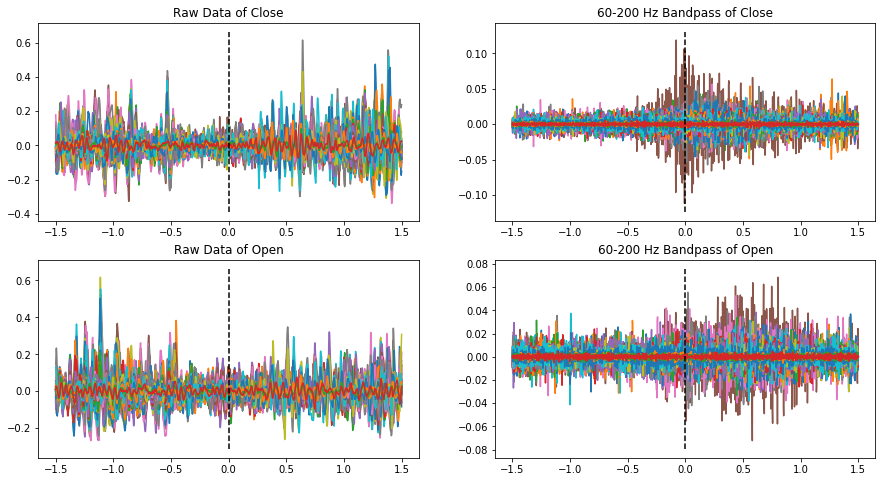

In [236]:
b, a = signal.butter(2, [freq_low, freq_high]/(0.5*fs), btype='bandpass')
gamma_close = signal.filtfilt(b, a, close_segments, axis = 0, padlen=(fs/2).astype(int))
gamma_open = signal.filtfilt(b, a, open_segments, axis = 0, padlen=(fs/2).astype(int))

print("Overlay plots of all channels for the first trial")

xt = np.linspace(-ms_before/1000.0, ms_after/1000.0, gamma_close.shape[0])
plt.subplot(2, 2, 1)
plt.title('Raw Data of Close')
plt.plot(xt, close_segments[:, : ,0])
plt.plot([0, 0], plt.gca().get_ylim(), 'k--')
plt.subplot(2, 2, 2)
plt.title('60-200 Hz Bandpass of Close')
plt.plot(xt, gamma_close[:, :, 0])
plt.plot([0, 0], plt.gca().get_ylim(), 'k--')

plt.subplot(2, 2, 3)
plt.title('Raw Data of Open')
plt.plot(xt, open_segments[:, : ,0])
plt.plot([0, 0], plt.gca().get_ylim(), 'k--')
plt.subplot(2, 2, 4)
plt.title('60-200 Hz Bandpass of Open')
plt.plot(xt, gamma_open[:, :, 0])
plt.plot([0, 0], plt.gca().get_ylim(), 'k--')

plt.gcf().set_size_inches(15, 8)
plt.show()

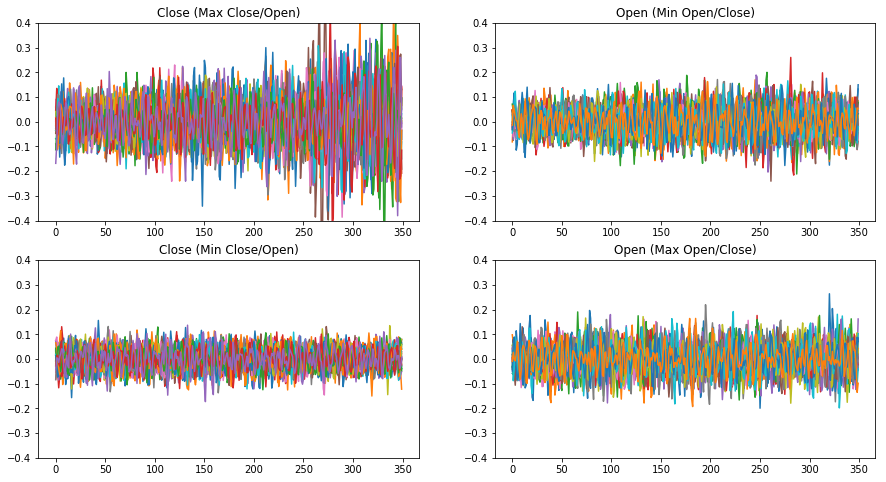

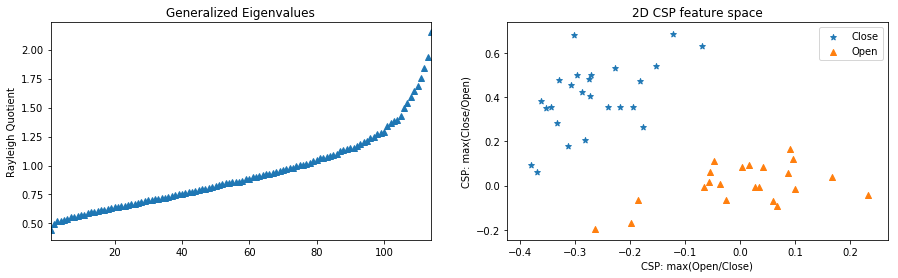

In [343]:
X = gamma_close[move_sample, :, :]
Y = gamma_open[move_sample, :, :]
num_trial_X = X.shape[2]
num_trial_Y = Y.shape[2]
num_channels = X.shape[1]

Cx=0 # Normalized Covariance Matrix for X
Cy=0 # Normalized Covariance Matrix for Y

# compute the normalized covariance matrix
for t in range(num_trial_X):
    ctmp = np.cov(X[:, :, t], rowvar = False)
    Cx += ctmp/np.trace(ctmp)
for t in range(num_trial_Y):
    ctmp = np.cov(Y[:, :, t], rowvar = False)
    Cy += ctmp/np.trace(ctmp)

    
Cx /= num_trial_X
Cy /=num_trial_Y

# generalized eigenvalue problem
W, V = eigh(Cx, Cy)

X_max_close = np.zeros((X.shape[0], X.shape[2]))
Y_max_close = np.zeros((Y.shape[0], Y.shape[2]))

X_max_open = np.zeros((X.shape[0], X.shape[2]))
Y_max_open = np.zeros((Y.shape[0], Y.shape[2]))

for t in range(num_trial_X):
    X_max_close[:, t] = np.dot(X[:, :, t], V[:, -1])
    X_max_open[:, t] = np.dot(X[:, :, t], V[:, 0])
    
for t in range(num_trial_Y):
    Y_max_close[:, t] = np.dot(Y[:, :, t], V[:, -1])
    Y_max_open[:, t] = np.dot(Y[:, :, t], V[:, 0])

feature_X = np.zeros((num_trial_X, 2))
feature_Y = np.zeros((num_trial_Y, 2))
for t in range(num_trial_X):
    feature_X[t, 0] = np.log10(np.sum(np.dot(X[:, :, t], V[:, 0])**2))
    feature_X[t, 1] = np.log10(np.sum(np.dot(X[:, :, t], V[:, -1])**2))
for t in range(num_trial_Y):
    feature_Y[t, 0] = np.log10(np.sum(np.dot(Y[:, :, t], V[:, 0])**2))
    feature_Y[t, 1] = np.log10(np.sum(np.dot(Y[:, :, t], V[:, -1])**2))


plt.figure()
plt.subplot(2, 2, 1)
plt.plot(X_max_close)
plt.title('Close (Max Close/Open)')
plt.ylim([-0.4, 0.4])

plt.subplot(2, 2, 2)
plt.plot(Y_max_close)
plt.title('Open (Min Open/Close)')
plt.ylim([-0.4, 0.4])

plt.subplot(2, 2, 3)
plt.plot(X_max_open)
plt.title('Close (Min Close/Open)')
plt.ylim([-0.4, 0.4])

plt.subplot(2, 2, 4)
plt.plot(Y_max_open)
plt.title('Open (Max Open/Close)')
plt.ylim([-0.4, 0.4])

plt.gcf().set_size_inches(15, 8)
plt.show()

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(range(1, W.shape[0]+1), W, '^')
plt.title('Generalized Eigenvalues')
plt.ylabel('Rayleigh Quotient')
plt.xlim([1, W.shape[0]])

plt.subplot(1, 2, 2)
plt.scatter(feature_X[:, 0], feature_X[:, 1], marker = '*')
plt.scatter(feature_Y[:, 0], feature_Y[:, 1], marker = '^')
plt.xlabel('CSP: max(Open/Close)')
plt.ylabel('CSP: max(Close/Open)')
plt.legend(('Close', 'Open'))
plt.title('2D CSP feature space')
plt.gcf().set_size_inches(15, 4)
plt.show()


In [344]:
np.random.seed(0)

num_filter = 1 # number of filters at each end
cardinality = 5
num_sessions = 125

num_train_X = int(num_trial_X*0.8)
num_train_Y = int(num_trial_Y*0.8)
num_test_X = num_trial_X-num_train_X
num_test_Y = num_trial_Y-num_train_Y

print('Number of sessions: %d'%num_sessions)
print('Number of training trials in each session: X: %d, Y: %d'% (num_train_X, num_train_Y))
print('Number of testing trials in each session: X: %d, Y: %d'% (num_test_X, num_test_Y))
# repeat for 125 sessions
err_test = np.zeros(num_sessions)
err_train = np.zeros(num_sessions)

for session in range(num_sessions):
    # random partition of training and testing trials
    randX = np.random.permutation(num_trial_X)
    randY = np.random.permutation(num_trial_Y)
    
    # get the CSP filters from the training set
    Cx = 0
    Cy = 0
    for t in range(num_train_X):
        ctmp = np.cov(X[:, :, randX[t]], rowvar = False)
        Cx += ctmp/np.trace(ctmp)
    for t in range(num_train_Y):
        ctmp = np.cov(Y[:, :, randY[t]], rowvar = False)
        Cy += ctmp/np.trace(ctmp)
    Cx /= num_train_X
    Cy /= num_train_Y
    W, V = eigh(Cx, Cy)
    
    # get the CSP features from the training set
    feature_train_X = np.zeros((num_train_X, num_filter*2))
    feature_train_Y = np.zeros((num_train_Y, num_filter*2))
    for t in range(num_train_X):
        for filter_ind in range(num_filter):
            feature_train_X[t, filter_ind] = np.log10(np.sum(np.dot(X[:, :, randX[t]], V[:, filter_ind])**2))
            feature_train_X[t, filter_ind+num_filter] = np.log10(np.sum(np.dot(X[:, :, randX[t]], V[:, -(filter_ind+1)])**2))
        
    for t in range(num_train_Y):
        for filter_ind in range(num_filter):
            feature_train_Y[t, filter_ind] = np.log10(np.sum(np.dot(Y[:, :, randY[t]], V[:, filter_ind])**2))
            feature_train_Y[t, filter_ind+num_filter] = np.log10(np.sum(np.dot(Y[:, :, randY[t]], V[:, -(filter_ind+1)])**2))
    
    # get the CSP features from the testing set
    feature_test_X = np.zeros((num_test_X, num_filter*2))
    feature_test_Y = np.zeros((num_test_Y, num_filter*2))
    for t in range(num_test_X):
        tt = t+num_train_X
        for filter_ind in range(num_filter):
                feature_test_X[t, filter_ind] = np.log10(np.sum(np.dot(X[:, :, randX[tt]], V[:, filter_ind])**2))
                feature_test_X[t, filter_ind+num_filter] = np.log10(np.sum(np.dot(X[:, :, randX[tt]], V[:, -(filter_ind+1)])**2))
                                                                                   
    for t in range(num_test_Y):
        tt = t+num_train_Y
        for filter_ind in range(num_filter):
            feature_test_Y[t, filter_ind] = np.log10(np.sum(np.dot(Y[:, :, randY[tt]], V[:, filter_ind])**2))
            feature_test_Y[t, filter_ind+num_filter] = np.log10(np.sum(np.dot(Y[:, :, randY[tt]], V[:, -(filter_ind+1)])**2))
    
    # combine the feature spaces from two classes
    train_feature = np.concatenate((feature_train_X, feature_train_Y), axis = 0)
    train_label = np.concatenate((np.zeros(num_train_X), np.ones(num_train_Y)))
    
    test_feature = np.concatenate((feature_test_X, feature_test_Y), axis = 0)
    test_label = np.concatenate((np.zeros(num_test_X), np.ones(num_test_Y)))
    
    # apply an LDA classifier
    clf = LinearDiscriminantAnalysis()                            
    clf.fit(train_feature, train_label)
    predict_train = clf.predict(train_feature)
    predict_test = clf.predict(test_feature)
    
    err_train[session] = np.sum((predict_train != train_label)/float(train_label.shape[0]))
    err_test[session] = np.sum((predict_test != test_label))/float(test_label.shape[0])

Number of sessions: 125
Number of training trials in each session: X: 20, Y: 17
Number of testing trials in each session: X: 5, Y: 5


In [345]:
print('Average Training Error Rate: %f, std: %f'% (np.mean(err_train), np.std(err_train)))
print('Average Testing Error Rate: %f, std: %f'% (np.mean(err_test), np.std(err_test)))

Average Training Error Rate: 0.000000, std: 0.000000
Average Testing Error Rate: 0.034400, std: 0.060800


# Sparse CSP
L0 normalization. Use only a few channels (5) to achieve comparable decoding accuracies

Pros:
    Reduce the overfiting problem of full channel CSP due to noisy channel
    Speed up the classifier decision in production (online decoding) envorinment
    
Cons:
    Difficult to solve as it is NP-hard
    Computationaly more expensive to search for parameter cardinality
    
## Practical Approachs

0, Greedy methods: forward selection and backward elimination

1, Recursive weight elimination (RWE)

2, Oscillating search (RWE + Greedy methods)